In [14]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
from datetime import datetime, timedelta
from scipy import stats
from scipy.stats import normaltest, shapiro, kstest
import json

# Configure display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
warnings.filterwarnings('ignore')

# Set style for matplotlib
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("📊 IoT Data EDA Notebook Initialized")
print(f"Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

📊 IoT Data EDA Notebook Initialized
Analysis Date: 2025-10-13 17:34:42


# IoT Data Exploratory Data Analysis (EDA)
## Comprehensive Statistical Analysis of IoT Telemetry, Failures, Maintenance, and Device Data

This notebook provides a thorough exploratory data analysis of the synthetic IoT dataset including:
- Data quality assessment
- Statistical summaries  
- Distribution analysis
- Correlation analysis
- Time series patterns
- Device performance insights

## 1. Data Loading and Initial Overview

In [15]:
# Data folder path
data_folder = "../sample_data"

# Load all datasets
print("Loading datasets...")
try:
    telemetry = pd.read_json(f"{data_folder}/telemetry.json")
    failures = pd.read_json(f"{data_folder}/failures.json")
    maintenance = pd.read_json(f"{data_folder}/maintenance.json")
    devices = pd.read_json(f"{data_folder}/device_master.json")
    
    print("✅ All datasets loaded successfully!")
    
    # Dataset overview
    datasets = {
        'Telemetry': telemetry,
        'Failures': failures,
        'Maintenance': maintenance,
        'Device Master': devices
    }
    
    print("\n📋 Dataset Overview:")
    print("=" * 50)
    for name, df in datasets.items():
        print(f"{name:15}: {len(df):,} records, {df.shape[1]} columns")
        
except FileNotFoundError as e:
    print(f"❌ Error loading data: {e}")
    print("Please ensure the data files exist in the sample_data folder")

Loading datasets...
✅ All datasets loaded successfully!

📋 Dataset Overview:
Telemetry      : 1,010 records, 8 columns
Failures       : 1 records, 10 columns
Maintenance    : 71 records, 12 columns
Device Master  : 100 records, 11 columns


In [16]:
# Display basic information about each dataset
print("\n🔍 Dataset Schemas:")
print("=" * 40)

for name, df in datasets.items():
    print(f"\n{name.upper()}:")
    print(f"Columns: {list(df.columns)}")
    print(f"Sample data:")
    display(df.head(3))


🔍 Dataset Schemas:

TELEMETRY:
Columns: ['device_id', 'timestamp', 'reading_type', 'value', 'unit', 'quality', 'location', 'facility']
Sample data:


,device_id,timestamp,reading_type,value,unit,quality,location,facility
0,DEV_HUMIDITY_SENSOR_0000,2025-10-13 15:21:51.881724,humidity,41.71,percent,good,Cold_Storage,Warehouse_2
1,DEV_FLOW_METER_0001,2025-10-13 15:21:51.881724,flow_rate,89.99,l/min,good,Dry_Storage,Warehouse_2
2,DEV_FLOW_METER_0003,2025-10-13 15:21:51.881724,flow_rate,92.87,l/min,good,HVAC_System,Office_Complex



FAILURES:
Columns: ['event_id', 'device_id', 'timestamp', 'failure_type', 'severity', 'description', 'location', 'facility', 'resolved', 'resolution_time']
Sample data:


,event_id,device_id,timestamp,failure_type,severity,description,location,facility,resolved,resolution_time
0,0495a085-5d94-4f86-8ac0-6f1313e76919,DEV_TEMPERATURE_SENSOR_0017,2025-10-04 16:21:51.885942,mechanical_failure,low,Mechanical component failure,Security_Entrance,Office_Complex,True,2025-10-04 20:21:51.885942



MAINTENANCE:
Columns: ['maintenance_id', 'device_id', 'maintenance_type', 'scheduled_date', 'actual_date', 'duration_hours', 'technician_id', 'description', 'parts_replaced', 'cost', 'location', 'facility']
Sample data:


,maintenance_id,device_id,maintenance_type,scheduled_date,actual_date,duration_hours,technician_id,description,parts_replaced,cost,location,facility
0,728a376c-b896-44a8-b378-d323e3fe2474,DEV_HUMIDITY_SENSOR_0000,preventive,2025-08-19T16:21:51.885983,2025-08-19T09:21:51.885983,2.5,TECH_1049,Routine preventive maintenance check,[communication_module],338.12,Cold_Storage,Warehouse_2
1,44ffe82a-4735-45ee-8c94-c85f9c8a25c4,DEV_FLOW_METER_0001,preventive,2025-07-19T16:21:51.886039,2025-07-18T20:21:51.886039,4.0,TECH_1044,Routine preventive maintenance check,[battery_backup],389.78,Dry_Storage,Warehouse_2
2,219812c3-f545-4da2-a16c-7cb260df11b2,DEV_FLOW_METER_0002,preventive,2025-08-20T16:21:51.886060,2025-08-21T12:21:51.886060,3.1,TECH_1039,Routine preventive maintenance check,[communication_module],394.13,Climate_Control,Warehouse_1



DEVICE MASTER:
Columns: ['device_id', 'device_type', 'location', 'facility', 'installation_date', 'firmware_version', 'model', 'manufacturer', 'status', 'last_maintenance', 'next_scheduled_maintenance']
Sample data:


,device_id,device_type,location,facility,installation_date,firmware_version,model,manufacturer,status,last_maintenance,next_scheduled_maintenance
0,DEV_HUMIDITY_SENSOR_0000,humidity_sensor,Cold_Storage,Warehouse_2,2024-07-15T16:21:51.880813,2.1.7,HUMIDITY_SENSOR-610,SmartDevices,active,2024-12-06T16:21:51.880813,2025-12-18T16:21:51.880834
1,DEV_FLOW_METER_0001,flow_meter,Dry_Storage,Warehouse_2,2025-06-18T16:21:51.880866,1.2.3,FLOW_METER-167,TechFlow,active,2025-07-26T16:21:51.880866,2025-11-27T16:21:51.880869
2,DEV_FLOW_METER_0002,flow_meter,Climate_Control,Warehouse_1,2024-10-14T16:21:51.880880,3.2.9,FLOW_METER-536,TechFlow,inactive,2025-03-06T16:21:51.880880,2025-11-14T16:21:51.880883


## 2. Device Master Data Analysis

In [18]:
# Convert datetime columns
devices['installation_date'] = pd.to_datetime(devices['installation_date'])
devices['last_maintenance'] = pd.to_datetime(devices['last_maintenance'])
devices['next_scheduled_maintenance'] = pd.to_datetime(devices['next_scheduled_maintenance'])

# Calculate derived metrics
devices['device_age_days'] = (datetime.now() - devices['installation_date']).dt.days
devices['days_since_maintenance'] = (datetime.now() - devices['last_maintenance']).dt.days
devices['days_to_next_maintenance'] = (devices['next_scheduled_maintenance'] - datetime.now()).dt.days

print("🏭 Device Master Data Analysis")
print("=" * 40)

# Device distribution by type
device_type_dist = devices['device_type'].value_counts()
print(f"\n📱 Device Types ({len(device_type_dist)} types):")
for device_type, count in device_type_dist.items():
    print(f"  {device_type:20}: {count:3d} ({count/len(devices)*100:.1f}%)")

# Status distribution
status_dist = devices['status'].value_counts()
print(f"\n🔧 Device Status:")
for status, count in status_dist.items():
    print(f"  {status:15}: {count:3d} ({count/len(devices)*100:.1f}%)")

# Facility and location distribution
facility_dist = devices['facility'].value_counts()
print(f"\n🏢 Facilities ({len(facility_dist)} facilities):")
for facility, count in facility_dist.items():
    print(f"  {facility:15}: {count:3d} devices")

# Age statistics
print(f"\n📅 Device Age Statistics:")
age_stats = devices['device_age_days'].describe()
for stat, value in age_stats.items():
    print(f"  {stat:10}: {value:.1f} days")

🏭 Device Master Data Analysis

📱 Device Types (8 types):
  motor_controller    :  18 (18.0%)
  power_meter         :  16 (16.0%)
  pressure_sensor     :  13 (13.0%)
  vibration_sensor    :  12 (12.0%)
  temperature_sensor  :  12 (12.0%)
  humidity_sensor     :  11 (11.0%)
  flow_meter          :  11 (11.0%)
  smart_valve         :   7 (7.0%)

🔧 Device Status:
  active         :  83 (83.0%)
  inactive       :   9 (9.0%)
  failed         :   6 (6.0%)
  maintenance    :   2 (2.0%)

🏢 Facilities (5 facilities):
  Factory_A      :  24 devices
  Warehouse_2    :  22 devices
  Office_Complex :  22 devices
  Warehouse_1    :  19 devices
  Factory_B      :  13 devices

📅 Device Age Statistics:
  count     : 100.0 days
  mean      : 555.7 days
  std       : 295.7 days
  min       : 5.0 days
  25%       : 298.2 days
  50%       : 537.0 days
  75%       : 786.2 days
  max       : 1072.0 days


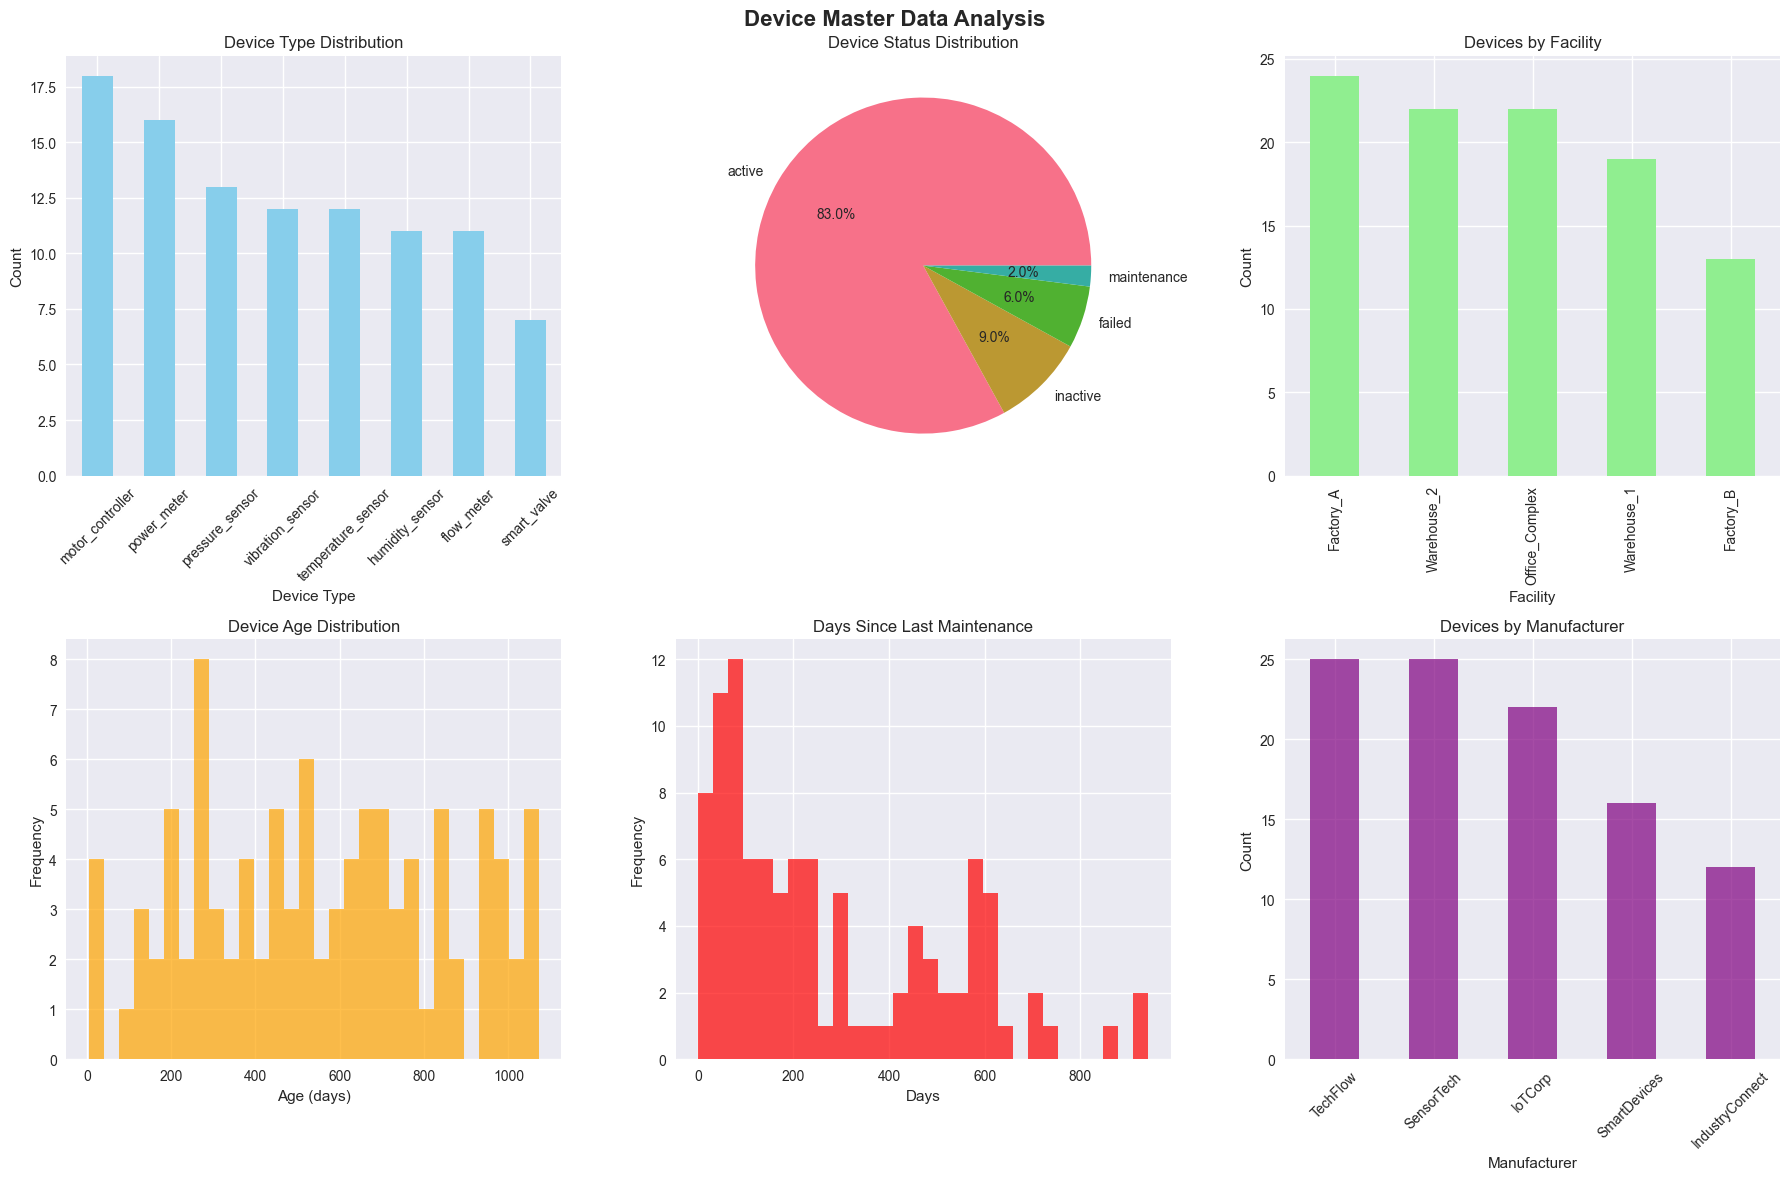

In [19]:
# Visualizations for Device Master Data
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Device Master Data Analysis', fontsize=16, fontweight='bold')

# Device type distribution
device_type_dist.plot(kind='bar', ax=axes[0,0], color='skyblue')
axes[0,0].set_title('Device Type Distribution')
axes[0,0].set_xlabel('Device Type')
axes[0,0].set_ylabel('Count')
axes[0,0].tick_params(axis='x', rotation=45)

# Status distribution
status_dist.plot(kind='pie', ax=axes[0,1], autopct='%1.1f%%')
axes[0,1].set_title('Device Status Distribution')
axes[0,1].set_ylabel('')

# Facility distribution
facility_dist.plot(kind='bar', ax=axes[0,2], color='lightgreen')
axes[0,2].set_title('Devices by Facility')
axes[0,2].set_xlabel('Facility')
axes[0,2].set_ylabel('Count')

# Device age distribution
axes[1,0].hist(devices['device_age_days'], bins=30, color='orange', alpha=0.7)
axes[1,0].set_title('Device Age Distribution')
axes[1,0].set_xlabel('Age (days)')
axes[1,0].set_ylabel('Frequency')

# Days since maintenance
axes[1,1].hist(devices['days_since_maintenance'], bins=30, color='red', alpha=0.7)
axes[1,1].set_title('Days Since Last Maintenance')
axes[1,1].set_xlabel('Days')
axes[1,1].set_ylabel('Frequency')

# Manufacturer distribution
manufacturer_dist = devices['manufacturer'].value_counts()
manufacturer_dist.plot(kind='bar', ax=axes[1,2], color='purple', alpha=0.7)
axes[1,2].set_title('Devices by Manufacturer')
axes[1,2].set_xlabel('Manufacturer')
axes[1,2].set_ylabel('Count')
axes[1,2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 4. Telemetry Data Analysis

In [20]:
# Convert timestamp column
telemetry['timestamp'] = pd.to_datetime(telemetry['timestamp'])

print("📡 Telemetry Data Analysis")
print("=" * 40)

# Basic statistics
print(f"\n📊 Basic Statistics:")
print(f"  Total readings: {len(telemetry):,}")
print(f"  Unique devices: {telemetry['device_id'].nunique()}")
print(f"  Reading types: {telemetry['reading_type'].nunique()}")
print(f"  Time period: {telemetry['timestamp'].min()} to {telemetry['timestamp'].max()}")
print(f"  Duration: {(telemetry['timestamp'].max() - telemetry['timestamp'].min()).days} days")

# Reading type distribution
reading_types = telemetry['reading_type'].value_counts()
print(f"\n🌡️ Reading Types:")
for reading_type, count in reading_types.items():
    print(f"  {reading_type:20}: {count:,} readings")

# Quality distribution
quality_dist = telemetry['quality'].value_counts()
print(f"\n✅ Data Quality Distribution:")
for quality, count in quality_dist.items():
    print(f"  {quality:10}: {count:,} ({count/len(telemetry)*100:.1f}%)")

# Statistical summary of values
print(f"\n📈 Value Statistics:")
value_stats = telemetry['value'].describe()
for stat, value in value_stats.items():
    print(f"  {stat:10}: {value:.2f}")

# Readings per device statistics
readings_per_device = telemetry.groupby('device_id').size()
print(f"\n📱 Readings per Device:")
device_stats = readings_per_device.describe()
for stat, value in device_stats.items():
    print(f"  {stat:10}: {value:.1f}")

📡 Telemetry Data Analysis

📊 Basic Statistics:
  Total readings: 1,010
  Unique devices: 83
  Reading types: 8
  Time period: 2025-10-13 15:21:51.881724 to 2025-10-13 16:21:51.881724
  Duration: 0 days

🌡️ Reading Types:
  rpm                 : 200 readings
  power               : 175 readings
  temperature         : 149 readings
  humidity            : 124 readings
  pressure            : 122 readings
  vibration           : 105 readings
  position            : 74 readings
  flow_rate           : 61 readings

✅ Data Quality Distribution:
  good      : 913 (90.4%)
  fair      : 79 (7.8%)
  poor      : 18 (1.8%)

📈 Value Statistics:
  count     : 1010.00
  mean      : 366.19
  std       : 666.15
  min       : 0.76
  25%       : 23.67
  50%       : 41.85
  75%       : 82.23
  max       : 1807.03

📱 Readings per Device:
  count     : 83.0
  mean      : 12.2
  std       : 0.8
  min       : 10.0
  25%       : 12.0
  50%       : 12.0
  75%       : 13.0
  max       : 13.0


In [ ]:
# Advanced telemetry analysis by reading type
print("\n🔬 Detailed Analysis by Reading Type:")
print("=" * 50)

telemetry_stats = []

for reading_type in telemetry['reading_type'].unique():
    subset = telemetry[telemetry['reading_type'] == reading_type]['value']
    
    stats_dict = {
        'reading_type': reading_type,
        'count': len(subset),
        'mean': subset.mean(),
        'std': subset.std(),
        'min': subset.min(),
        'max': subset.max(),
        'skewness': stats.skew(subset),
        'kurtosis': stats.kurtosis(subset),
        'cv': subset.std() / subset.mean() if subset.mean() != 0 else 0  # Coefficient of variation
    }
    
    telemetry_stats.append(stats_dict)
    
    print(f"\n{reading_type.upper()}:")
    print(f"  Count: {stats_dict['count']:,}")
    print(f"  Mean: {stats_dict['mean']:.2f}")
    print(f"  Std Dev: {stats_dict['std']:.2f}")
    print(f"  Range: [{stats_dict['min']:.2f}, {stats_dict['max']:.2f}]")
    print(f"  Skewness: {stats_dict['skewness']:.2f}")
    print(f"  Kurtosis: {stats_dict['kurtosis']:.2f}")
    print(f"  Coeff. of Variation: {stats_dict['cv']:.2f}")

telemetry_stats_df = pd.DataFrame(telemetry_stats)
print("\n📋 Summary Statistics Table:")
display(telemetry_stats_df.round(2))

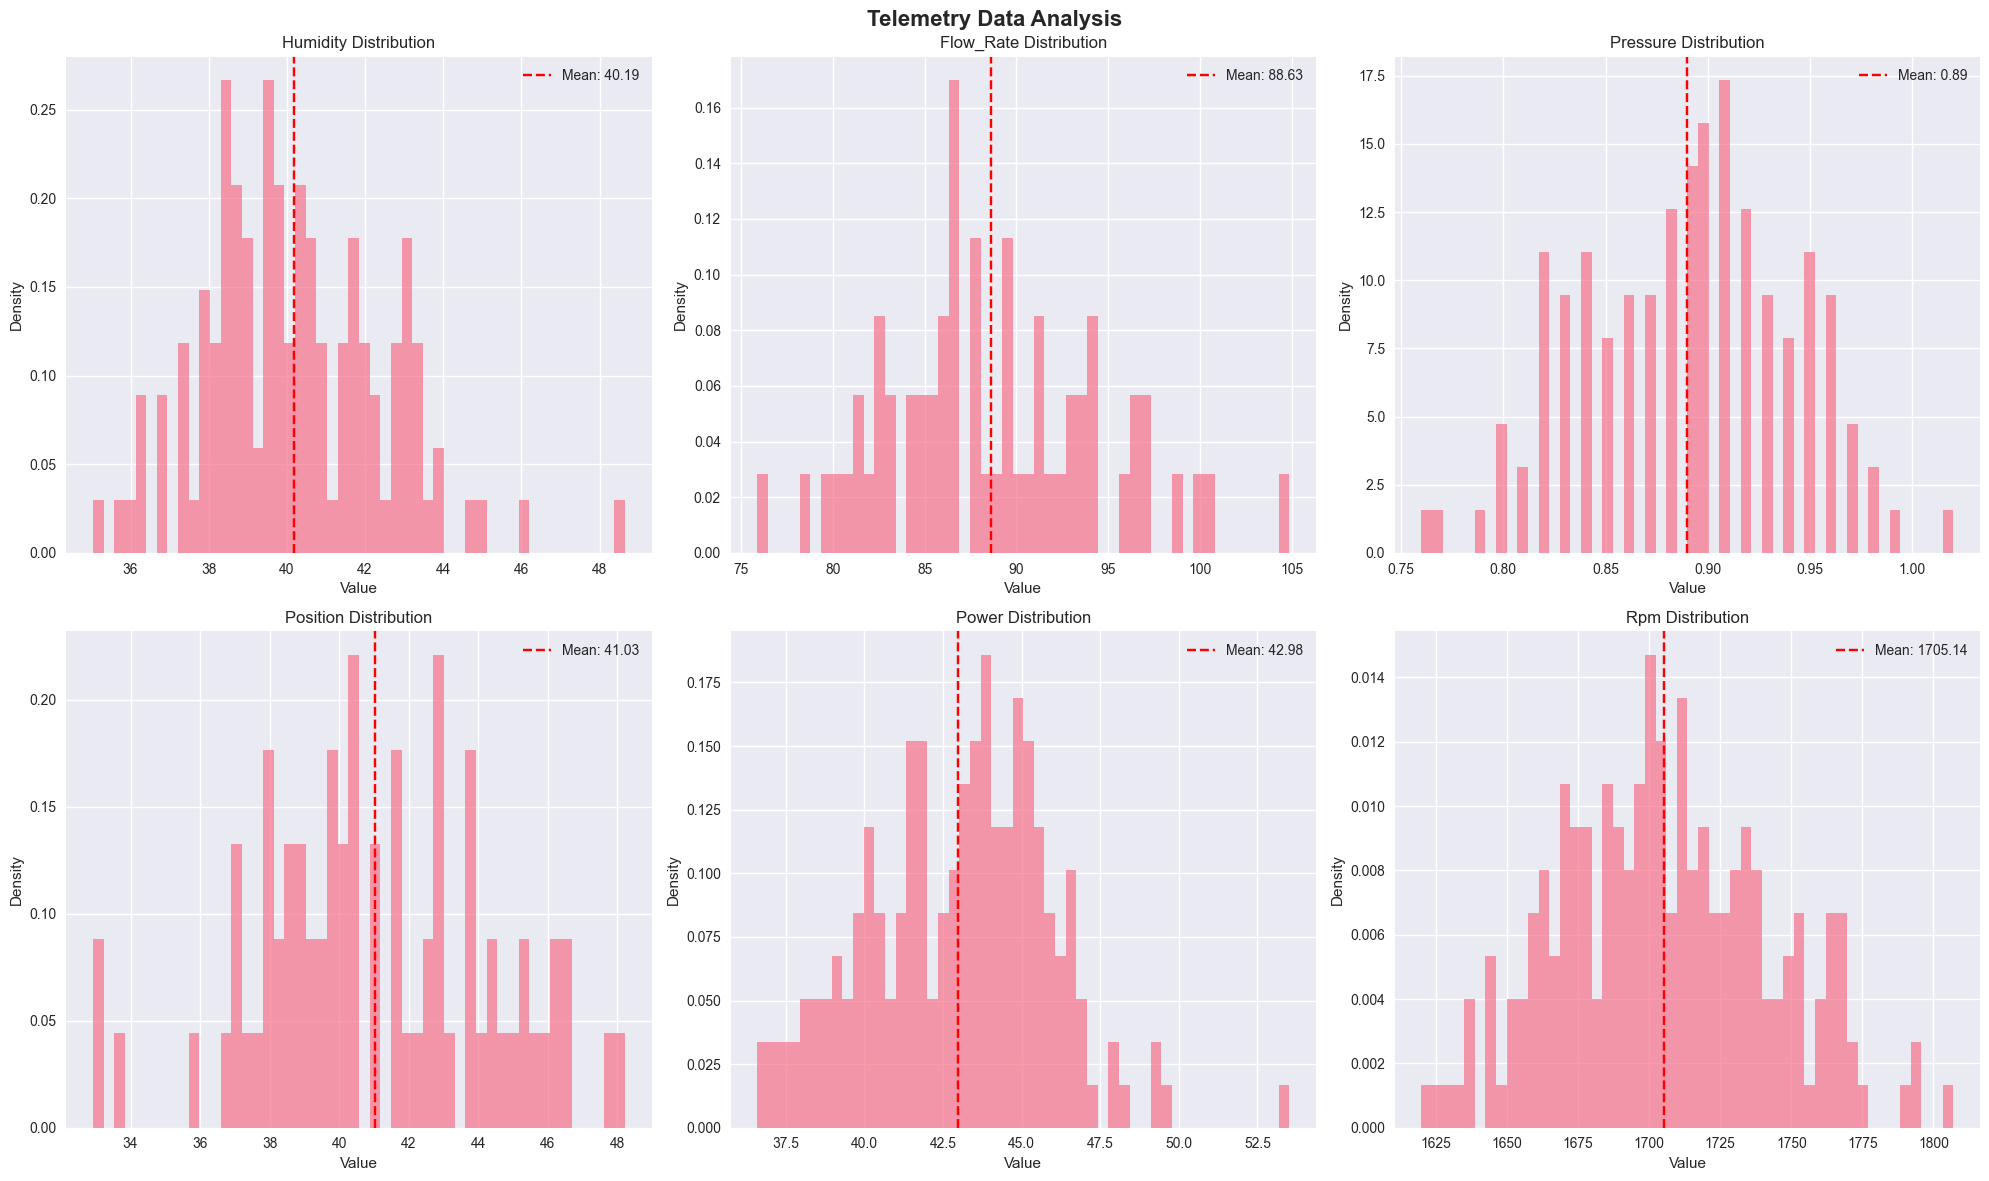

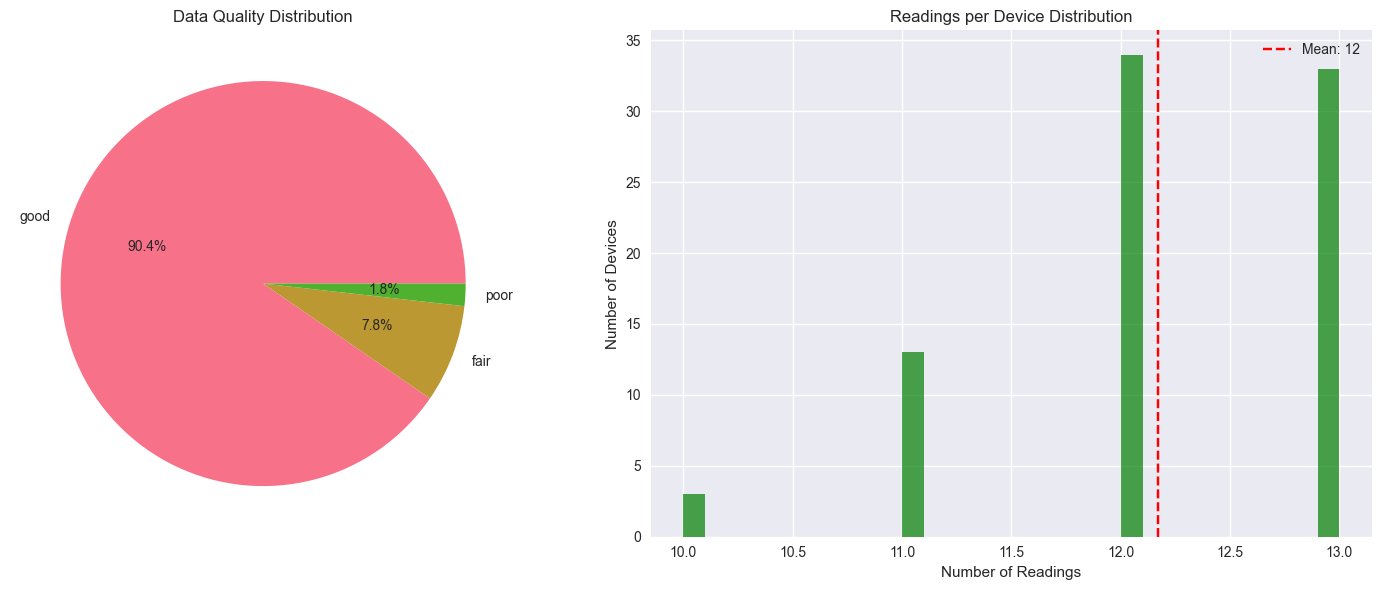

In [21]:
# Telemetry visualizations
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Telemetry Data Analysis', fontsize=16, fontweight='bold')

# Value distribution by reading type
reading_types_list = list(telemetry['reading_type'].unique())
for i in range(min(6, len(reading_types_list))):
    row, col = i // 3, i % 3
    reading_type = reading_types_list[i]
    subset = telemetry[telemetry['reading_type'] == reading_type]['value']
    
    axes[row, col].hist(subset, bins=50, alpha=0.7, density=True)
    axes[row, col].set_title(f'{reading_type.title()} Distribution')
    axes[row, col].set_xlabel('Value')
    axes[row, col].set_ylabel('Density')
    
    # Add mean line
    axes[row, col].axvline(subset.mean(), color='red', linestyle='--', 
                          label=f'Mean: {subset.mean():.2f}')
    axes[row, col].legend()

plt.tight_layout()
plt.show()

# Quality distribution and readings per device
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Quality distribution
quality_dist.plot(kind='pie', ax=ax1, autopct='%1.1f%%')
ax1.set_title('Data Quality Distribution')
ax1.set_ylabel('')

# Readings per device distribution
ax2.hist(readings_per_device, bins=30, alpha=0.7, color='green')
ax2.set_title('Readings per Device Distribution')
ax2.set_xlabel('Number of Readings')
ax2.set_ylabel('Number of Devices')
ax2.axvline(readings_per_device.mean(), color='red', linestyle='--',
           label=f'Mean: {readings_per_device.mean():.0f}')
ax2.legend()

plt.tight_layout()
plt.show()

## 5. Time Series Analysis

In [22]:
# Time series analysis
print("📈 Time Series Analysis")
print("=" * 40)

# Hourly patterns
telemetry['hour'] = telemetry['timestamp'].dt.hour
telemetry['day_of_week'] = telemetry['timestamp'].dt.dayofweek
telemetry['date'] = telemetry['timestamp'].dt.date

# Hourly reading patterns
hourly_counts = telemetry['hour'].value_counts().sort_index()
print(f"\n🕒 Readings by Hour of Day:")
print(f"Peak hour: {hourly_counts.idxmax()}:00 ({hourly_counts.max():,} readings)")
print(f"Low hour: {hourly_counts.idxmin()}:00 ({hourly_counts.min():,} readings)")

# Daily patterns
daily_counts = telemetry['day_of_week'].value_counts().sort_index()
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
print(f"\n📅 Readings by Day of Week:")
for i, day in enumerate(days):
    if i in daily_counts.index:
        print(f"  {day:10}: {daily_counts[i]:,} readings")

# Sample a few devices for detailed time series
sample_devices = telemetry['device_id'].unique()[:5]
print(f"\n📊 Sample Device Time Series:")
for device in sample_devices:
    device_data = telemetry[telemetry['device_id'] == device]
    print(f"  {device}: {len(device_data)} readings over {device_data['timestamp'].nunique()} time points")

📈 Time Series Analysis

🕒 Readings by Hour of Day:
Peak hour: 15:00 (623 readings)
Low hour: 16:00 (387 readings)

📅 Readings by Day of Week:
  Monday    : 1,010 readings

📊 Sample Device Time Series:
  DEV_HUMIDITY_SENSOR_0000: 13 readings over 13 time points
  DEV_FLOW_METER_0001: 13 readings over 13 time points
  DEV_FLOW_METER_0003: 11 readings over 11 time points
  DEV_PRESSURE_SENSOR_0004: 12 readings over 12 time points
  DEV_FLOW_METER_0005: 13 readings over 13 time points


ValueError: The number of FixedLocator locations (1), usually from a call to set_ticks, does not match the number of labels (7).

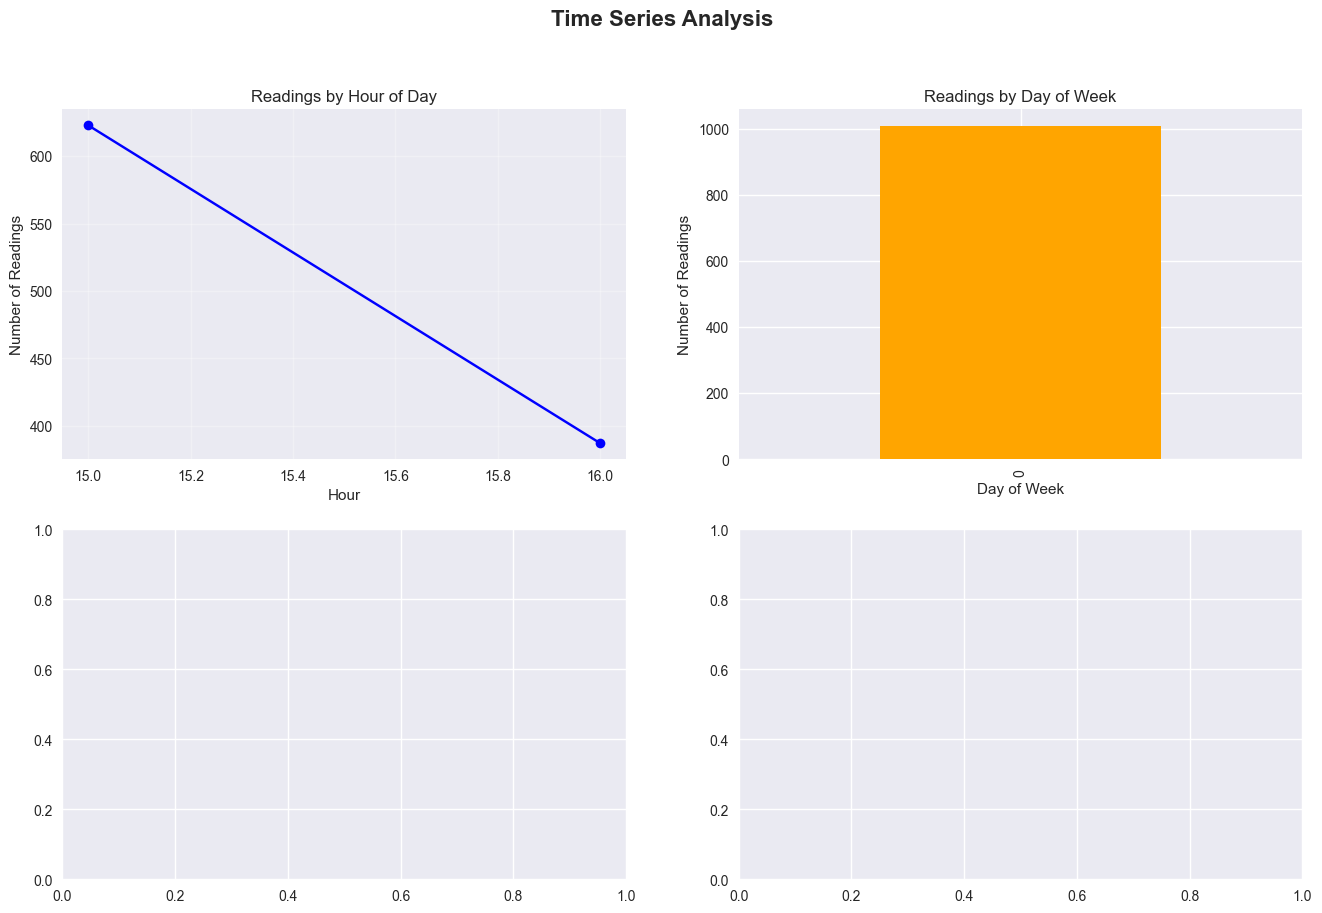

In [23]:
# Time series visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Time Series Analysis', fontsize=16, fontweight='bold')

# Hourly patterns
hourly_counts.plot(kind='line', ax=axes[0,0], marker='o', color='blue')
axes[0,0].set_title('Readings by Hour of Day')
axes[0,0].set_xlabel('Hour')
axes[0,0].set_ylabel('Number of Readings')
axes[0,0].grid(True, alpha=0.3)

# Daily patterns
daily_counts.plot(kind='bar', ax=axes[0,1], color='orange')
axes[0,1].set_title('Readings by Day of Week')
axes[0,1].set_xlabel('Day of Week')
axes[0,1].set_ylabel('Number of Readings')
axes[0,1].set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], rotation=0)

# Daily readings over time
daily_readings = telemetry.groupby('date').size()
daily_readings.plot(kind='line', ax=axes[1,0], color='green')
axes[1,0].set_title('Daily Readings Over Time')
axes[1,0].set_xlabel('Date')
axes[1,0].set_ylabel('Number of Readings')
axes[1,0].tick_params(axis='x', rotation=45)

# Sample device time series
sample_device = sample_devices[0]
device_ts = telemetry[telemetry['device_id'] == sample_device].sort_values('timestamp')
axes[1,1].plot(device_ts['timestamp'], device_ts['value'], alpha=0.7, color='red')
axes[1,1].set_title(f'Sample Device Time Series: {sample_device}')
axes[1,1].set_xlabel('Time')
axes[1,1].set_ylabel('Value')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 6. Failure Event Analysis

In [24]:
# Failure analysis
failures['timestamp'] = pd.to_datetime(failures['timestamp'])
failures['resolution_time'] = pd.to_datetime(failures['resolution_time'])

print("⚠️ Failure Event Analysis")
print("=" * 40)

print(f"\n📊 Basic Failure Statistics:")
print(f"  Total failures: {len(failures):,}")
print(f"  Affected devices: {failures['device_id'].nunique()}")
print(f"  Resolution rate: {(failures['resolved'].sum() / len(failures) * 100):.1f}%")

# Failure type distribution
failure_types = failures['failure_type'].value_counts()
print(f"\n🔧 Failure Types:")
for failure_type, count in failure_types.items():
    print(f"  {failure_type:25}: {count:3d} ({count/len(failures)*100:.1f}%)")

# Severity distribution
severity_dist = failures['severity'].value_counts()
print(f"\n⚡ Severity Distribution:")
for severity, count in severity_dist.items():
    print(f"  {severity:10}: {count:3d} ({count/len(failures)*100:.1f}%)")

# Resolution time analysis (for resolved failures)
resolved_failures = failures[failures['resolved'] == True].copy()
if len(resolved_failures) > 0:
    resolved_failures['resolution_hours'] = (
        resolved_failures['resolution_time'] - resolved_failures['timestamp']
    ).dt.total_seconds() / 3600
    
    print(f"\n⏱️ Resolution Time Statistics (hours):")
    resolution_stats = resolved_failures['resolution_hours'].describe()
    for stat, value in resolution_stats.items():
        print(f"  {stat:10}: {value:.1f} hours")

# Failures by facility
facility_failures = failures.groupby('facility').size().sort_values(ascending=False)
print(f"\n🏢 Failures by Facility:")
for facility, count in facility_failures.items():
    print(f"  {facility:15}: {count:3d} failures")

⚠️ Failure Event Analysis

📊 Basic Failure Statistics:
  Total failures: 1
  Affected devices: 1
  Resolution rate: 100.0%

🔧 Failure Types:
  mechanical_failure       :   1 (100.0%)

⚡ Severity Distribution:
  low       :   1 (100.0%)

⏱️ Resolution Time Statistics (hours):
  count     : 1.0 hours
  mean      : 4.0 hours
  std       : nan hours
  min       : 4.0 hours
  25%       : 4.0 hours
  50%       : 4.0 hours
  75%       : 4.0 hours
  max       : 4.0 hours

🏢 Failures by Facility:
  Office_Complex :   1 failures


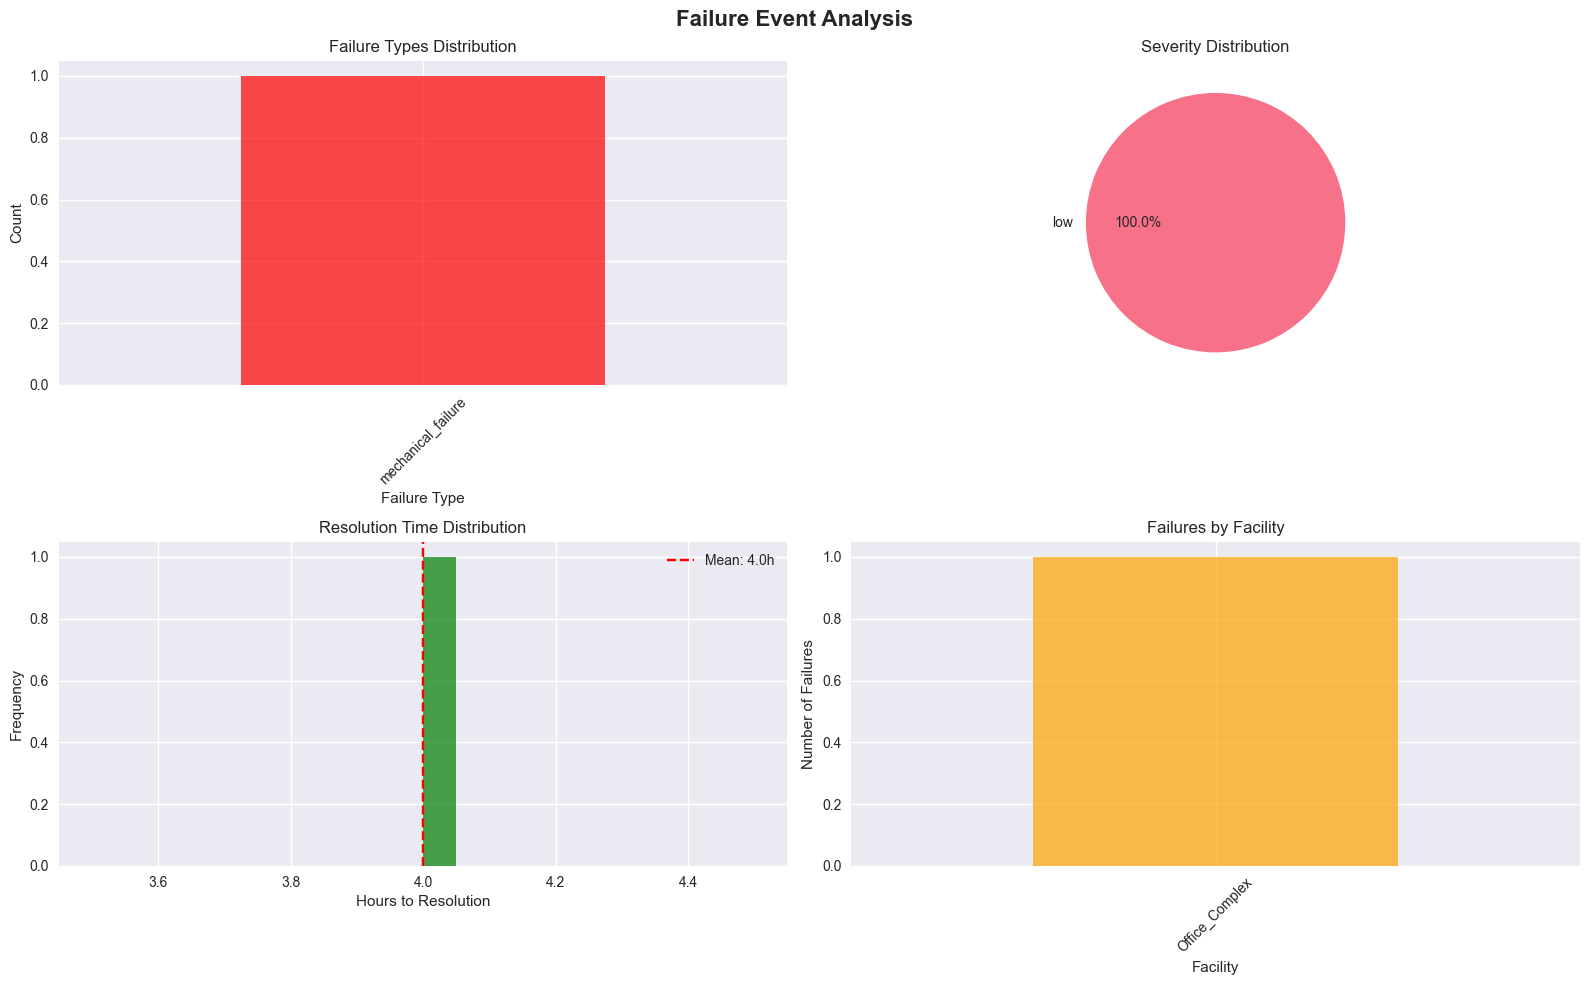

In [25]:
# Failure visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Failure Event Analysis', fontsize=16, fontweight='bold')

# Failure type distribution
failure_types.plot(kind='bar', ax=axes[0,0], color='red', alpha=0.7)
axes[0,0].set_title('Failure Types Distribution')
axes[0,0].set_xlabel('Failure Type')
axes[0,0].set_ylabel('Count')
axes[0,0].tick_params(axis='x', rotation=45)

# Severity distribution
severity_dist.plot(kind='pie', ax=axes[0,1], autopct='%1.1f%%')
axes[0,1].set_title('Severity Distribution')
axes[0,1].set_ylabel('')

# Resolution time distribution
if len(resolved_failures) > 0:
    axes[1,0].hist(resolved_failures['resolution_hours'], bins=20, alpha=0.7, color='green')
    axes[1,0].set_title('Resolution Time Distribution')
    axes[1,0].set_xlabel('Hours to Resolution')
    axes[1,0].set_ylabel('Frequency')
    axes[1,0].axvline(resolved_failures['resolution_hours'].mean(), color='red', linestyle='--',
                     label=f'Mean: {resolved_failures["resolution_hours"].mean():.1f}h')
    axes[1,0].legend()

# Failures by facility
facility_failures.plot(kind='bar', ax=axes[1,1], color='orange', alpha=0.7)
axes[1,1].set_title('Failures by Facility')
axes[1,1].set_xlabel('Facility')
axes[1,1].set_ylabel('Number of Failures')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 7. Maintenance Analysis

In [26]:
# Maintenance analysis
maintenance['scheduled_date'] = pd.to_datetime(maintenance['scheduled_date'])
maintenance['actual_date'] = pd.to_datetime(maintenance['actual_date'])

print("🔧 Maintenance Analysis")
print("=" * 40)

print(f"\n📊 Basic Maintenance Statistics:")
print(f"  Total maintenance records: {len(maintenance):,}")
print(f"  Devices maintained: {maintenance['device_id'].nunique()}")
print(f"  Average cost per maintenance: ${maintenance['cost'].mean():.2f}")
print(f"  Total maintenance cost: ${maintenance['cost'].sum():,.2f}")

# Maintenance type distribution
maintenance_types = maintenance['maintenance_type'].value_counts()
print(f"\n🔧 Maintenance Types:")
for maint_type, count in maintenance_types.items():
    print(f"  {maint_type:20}: {count:3d} ({count/len(maintenance)*100:.1f}%)")
    avg_cost = maintenance[maintenance['maintenance_type'] == maint_type]['cost'].mean()
    print(f"    Average cost: ${avg_cost:.2f}")

# Duration analysis
print(f"\n⏱️ Duration Statistics:")
duration_stats = maintenance['duration_hours'].describe()
for stat, value in duration_stats.items():
    print(f"  {stat:10}: {value:.1f} hours")

# Cost analysis by maintenance type
print(f"\n💰 Cost Analysis:")
cost_by_type = maintenance.groupby('maintenance_type')['cost'].agg(['mean', 'sum', 'count'])
print(cost_by_type.round(2))

# Maintenance scheduling analysis
maintenance['schedule_variance_days'] = (
    maintenance['actual_date'] - maintenance['scheduled_date']
).dt.days
print(f"\n📅 Schedule Variance:")
print(f"  On-time maintenance: {(maintenance['schedule_variance_days'] == 0).sum()} records")
print(f"  Early maintenance: {(maintenance['schedule_variance_days'] < 0).sum()} records")
print(f"  Late maintenance: {(maintenance['schedule_variance_days'] > 0).sum()} records")
print(f"  Average delay: {maintenance['schedule_variance_days'].mean():.1f} days")

🔧 Maintenance Analysis

📊 Basic Maintenance Statistics:
  Total maintenance records: 71
  Devices maintained: 71
  Average cost per maintenance: $367.35
  Total maintenance cost: $26,081.88

🔧 Maintenance Types:
  preventive          :  46 (64.8%)
    Average cost: $340.14
  predictive          :  13 (18.3%)
    Average cost: $230.66
  corrective          :   7 (9.9%)
    Average cost: $521.05
  emergency           :   5 (7.0%)
    Average cost: $757.96

⏱️ Duration Statistics:
  count     : 71.0 hours
  mean      : 3.2 hours
  std       : 2.0 hours
  min       : 0.8 hours
  25%       : 1.8 hours
  50%       : 2.8 hours
  75%       : 3.7 hours
  max       : 11.3 hours

💰 Cost Analysis:
                    mean       sum  count
maintenance_type                         
corrective        521.05   3647.34      7
emergency         757.96   3789.80      5
predictive        230.66   2998.52     13
preventive        340.14  15646.22     46

📅 Schedule Variance:
  On-time maintenance: 22 recor

## 8. Cross-Dataset Correlation Analysis

In [27]:
# Cross-dataset correlation analysis
print("🔗 Cross-Dataset Correlation Analysis")
print("=" * 50)

# Create aggregated dataset for correlation analysis
device_summary = devices[['device_id', 'device_type', 'facility', 'manufacturer', 
                         'status', 'device_age_days', 'days_since_maintenance']].copy()

# Telemetry aggregations per device
telemetry_agg = telemetry.groupby('device_id').agg({
    'value': ['mean', 'std', 'count'],
    'quality': lambda x: (x == 'poor').sum() / len(x)
}).round(4)
telemetry_agg.columns = ['avg_reading', 'reading_std', 'reading_count', 'poor_quality_ratio']

# Failure counts per device
failure_counts = failures.groupby('device_id').agg({
    'event_id': 'count',
    'severity': lambda x: (x == 'high').sum(),
    'resolved': lambda x: (~x).sum()
})
failure_counts.columns = ['failure_count', 'high_severity_count', 'unresolved_count']

# Maintenance costs per device
maintenance_agg = maintenance.groupby('device_id').agg({
    'cost': ['sum', 'count', 'mean'],
    'duration_hours': 'sum'
})
maintenance_agg.columns = ['total_maintenance_cost', 'maintenance_count', 'avg_maintenance_cost', 'total_maintenance_hours']

# Combine all datasets
combined_data = device_summary.set_index('device_id')
combined_data = combined_data.join(telemetry_agg, how='left')
combined_data = combined_data.join(failure_counts, how='left')
combined_data = combined_data.join(maintenance_agg, how='left')

# Fill missing values with 0
combined_data = combined_data.fillna(0)

# Encode categorical variables for correlation
from sklearn.preprocessing import LabelEncoder
categorical_columns = ['device_type', 'facility', 'manufacturer', 'status']
for col in categorical_columns:
    le = LabelEncoder()
    combined_data[f'{col}_encoded'] = le.fit_transform(combined_data[col])

print(f"✅ Combined dataset created with {len(combined_data)} devices and {len(combined_data.columns)} features")
print(f"\nFeatures: {list(combined_data.columns)}")

# Select numeric columns for correlation
numeric_columns = [col for col in combined_data.columns if combined_data[col].dtype in ['int64', 'float64']]
correlation_data = combined_data[numeric_columns]

print(f"\n📊 Correlation analysis on {len(numeric_columns)} numeric features")
display(combined_data.head())

🔗 Cross-Dataset Correlation Analysis
✅ Combined dataset created with 100 devices and 21 features

Features: ['device_type', 'facility', 'manufacturer', 'status', 'device_age_days', 'days_since_maintenance', 'avg_reading', 'reading_std', 'reading_count', 'poor_quality_ratio', 'failure_count', 'high_severity_count', 'unresolved_count', 'total_maintenance_cost', 'maintenance_count', 'avg_maintenance_cost', 'total_maintenance_hours', 'device_type_encoded', 'facility_encoded', 'manufacturer_encoded', 'status_encoded']

📊 Correlation analysis on 17 numeric features
✅ Combined dataset created with 100 devices and 21 features

Features: ['device_type', 'facility', 'manufacturer', 'status', 'device_age_days', 'days_since_maintenance', 'avg_reading', 'reading_std', 'reading_count', 'poor_quality_ratio', 'failure_count', 'high_severity_count', 'unresolved_count', 'total_maintenance_cost', 'maintenance_count', 'avg_maintenance_cost', 'total_maintenance_hours', 'device_type_encoded', 'facility_enco

,device_type,facility,manufacturer,status,device_age_days,days_since_maintenance,avg_reading,reading_std,reading_count,poor_quality_ratio,failure_count,high_severity_count,unresolved_count,total_maintenance_cost,maintenance_count,avg_maintenance_cost,total_maintenance_hours,device_type_encoded,facility_encoded,manufacturer_encoded,status_encoded
device_id,,,,,,,,,,,,,,,,,,,,,
DEV_HUMIDITY_SENSOR_0000,humidity_sensor,Warehouse_2,SmartDevices,active,455,311,40.2338,2.5176,13.0,0.0769,0.0,0.0,0.0,338.12,1.0,338.12,2.5,1,4,3,0
DEV_FLOW_METER_0001,flow_meter,Warehouse_2,TechFlow,active,117,79,87.0985,4.0168,13.0,0.0000,0.0,0.0,0.0,389.78,1.0,389.78,4.0,0,4,4,0
DEV_FLOW_METER_0002,flow_meter,Warehouse_1,TechFlow,inactive,364,221,0.0000,0.0000,0.0,0.0000,0.0,0.0,0.0,394.13,1.0,394.13,3.1,0,3,4,2
DEV_FLOW_METER_0003,flow_meter,Office_Complex,TechFlow,active,480,248,93.1700,4.6266,11.0,0.0909,0.0,0.0,0.0,202.50,1.0,202.50,2.7,0,2,4,0
DEV_PRESSURE_SENSOR_0004,pressure_sensor,Warehouse_1,TechFlow,active,281,141,0.8950,0.0385,12.0,0.0000,0.0,0.0,0.0,354.49,1.0,354.49,3.9,4,3,4,0


🔍 Strong Correlations (|r| >= 0.3):


,feature1,feature2,correlation
4,total_maintenance_cost,avg_maintenance_cost,1.000000
1,avg_reading,reading_std,0.970196
2,reading_count,status_encoded,-0.916102
5,total_maintenance_cost,total_maintenance_hours,0.882366
8,avg_maintenance_cost,total_maintenance_hours,0.882366
3,total_maintenance_cost,maintenance_count,0.731366
6,maintenance_count,avg_maintenance_cost,0.731366
7,maintenance_count,total_maintenance_hours,0.651491
0,device_age_days,days_since_maintenance,0.635089
9,manufacturer_encoded,status_encoded,0.301007


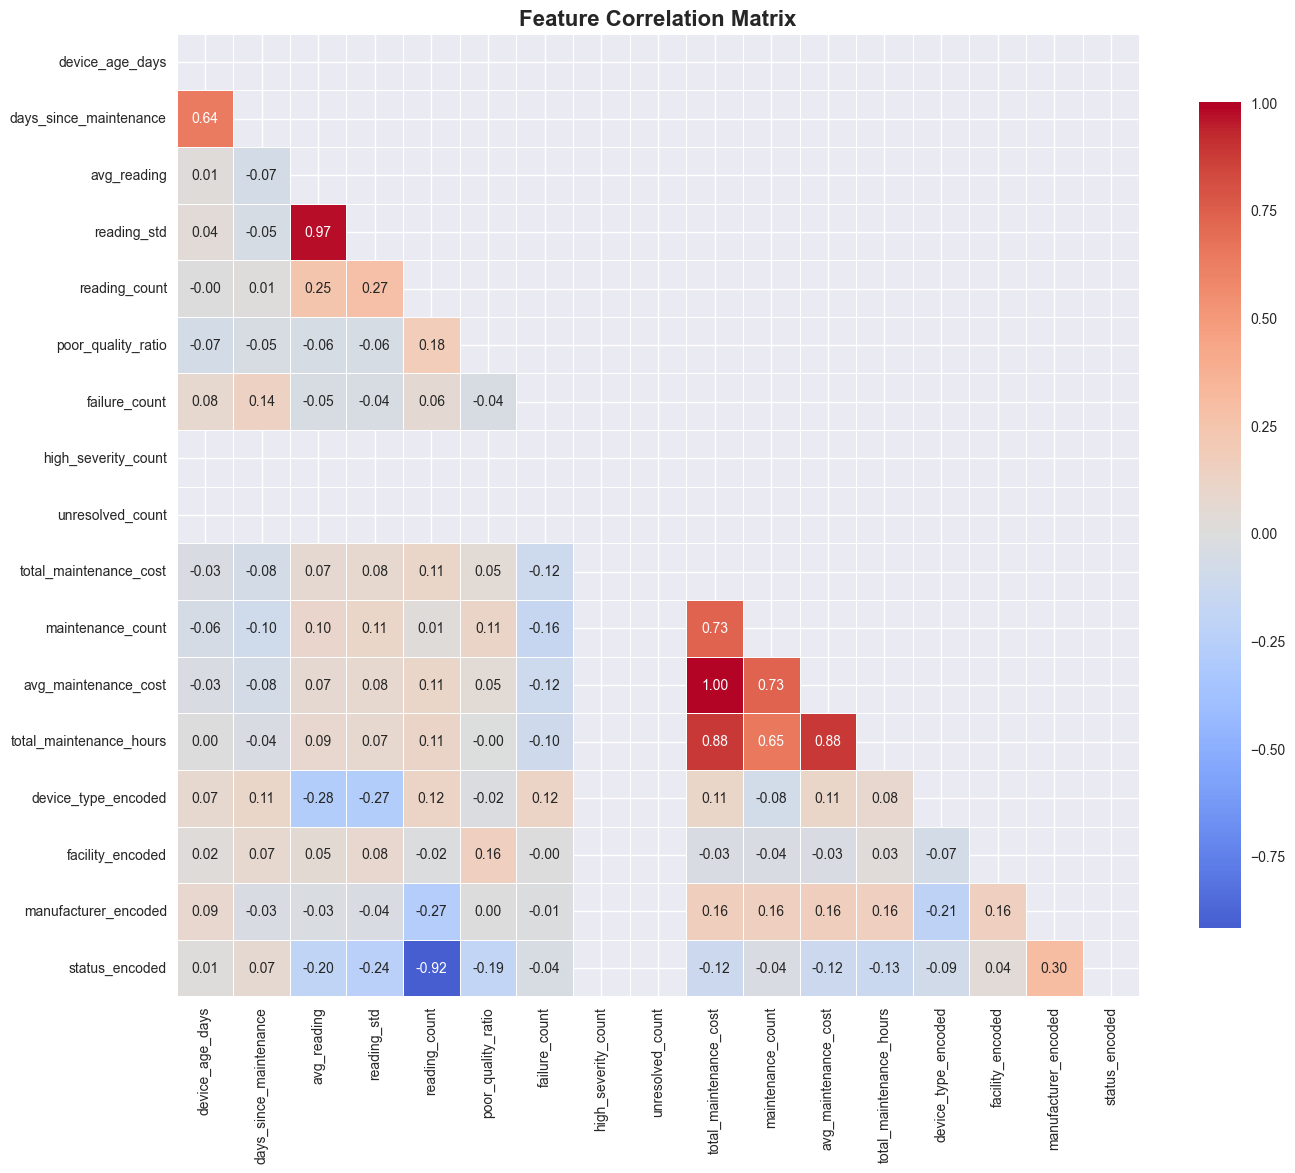


🎯 Key Correlation Insights:
• Device age vs maintenance frequency: r = -0.060
• Failure count vs maintenance cost: r = -0.115
• Poor reading quality vs failures: r = -0.044


In [28]:
# Correlation matrix and visualizations
correlation_matrix = correlation_data.corr()

# Find strongest correlations
def find_strong_correlations(corr_matrix, threshold=0.5):
    """Find correlations above threshold"""
    strong_corr = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            corr_val = corr_matrix.iloc[i, j]
            if abs(corr_val) >= threshold:
                strong_corr.append({
                    'feature1': corr_matrix.columns[i],
                    'feature2': corr_matrix.columns[j],
                    'correlation': corr_val
                })
    return pd.DataFrame(strong_corr).sort_values('correlation', key=abs, ascending=False)

strong_correlations = find_strong_correlations(correlation_matrix, 0.3)
print("🔍 Strong Correlations (|r| >= 0.3):")
if len(strong_correlations) > 0:
    display(strong_correlations)
else:
    print("No strong correlations found above threshold")

# Correlation heatmap
plt.figure(figsize=(14, 12))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": .8}, fmt='.2f')
plt.title('Feature Correlation Matrix', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Key insights from correlation analysis
print("\n🎯 Key Correlation Insights:")
print("=" * 40)

# Device age vs maintenance
age_maintenance_corr = correlation_matrix.loc['device_age_days', 'maintenance_count']
print(f"• Device age vs maintenance frequency: r = {age_maintenance_corr:.3f}")

# Failures vs maintenance cost
if 'failure_count' in correlation_matrix.columns and 'total_maintenance_cost' in correlation_matrix.columns:
    failure_cost_corr = correlation_matrix.loc['failure_count', 'total_maintenance_cost']
    print(f"• Failure count vs maintenance cost: r = {failure_cost_corr:.3f}")

# Reading quality vs failures
if 'poor_quality_ratio' in correlation_matrix.columns and 'failure_count' in correlation_matrix.columns:
    quality_failure_corr = correlation_matrix.loc['poor_quality_ratio', 'failure_count']
    print(f"• Poor reading quality vs failures: r = {quality_failure_corr:.3f}")

## 9. Statistical Tests and Distribution Analysis

In [29]:
# Statistical tests and distribution analysis
print("📈 Statistical Tests and Distribution Analysis")
print("=" * 55)

# Normality tests for telemetry values by reading type
print("\n🔬 Normality Tests for Telemetry Data:")
print("-" * 45)

normality_results = []
for reading_type in telemetry['reading_type'].unique():
    subset = telemetry[telemetry['reading_type'] == reading_type]['value']
    
    # Skip if too few samples
    if len(subset) < 8:
        continue
        
    # Shapiro-Wilk test (for small samples)
    if len(subset) <= 5000:
        shapiro_stat, shapiro_p = shapiro(subset)
    else:
        shapiro_stat, shapiro_p = None, None
    
    # D'Agostino normality test
    try:
        dagostino_stat, dagostino_p = normaltest(subset)
    except:
        dagostino_stat, dagostino_p = None, None
    
    result = {
        'reading_type': reading_type,
        'n_samples': len(subset),
        'shapiro_stat': shapiro_stat,
        'shapiro_p': shapiro_p,
        'dagostino_stat': dagostino_stat,
        'dagostino_p': dagostino_p,
        'is_normal_shapiro': shapiro_p > 0.05 if shapiro_p else None,
        'is_normal_dagostino': dagostino_p > 0.05 if dagostino_p else None
    }
    
    normality_results.append(result)
    
    print(f"\n{reading_type.upper()}:")
    print(f"  Sample size: {len(subset):,}")
    if shapiro_p:
        print(f"  Shapiro-Wilk p-value: {shapiro_p:.4f} ({'Normal' if shapiro_p > 0.05 else 'Non-normal'})")
    if dagostino_p:
        print(f"  D'Agostino p-value: {dagostino_p:.4f} ({'Normal' if dagostino_p > 0.05 else 'Non-normal'})")

normality_df = pd.DataFrame(normality_results)
if len(normality_df) > 0:
    print("\n📋 Normality Test Summary:")
    display(normality_df.round(4))

📈 Statistical Tests and Distribution Analysis

🔬 Normality Tests for Telemetry Data:
---------------------------------------------

HUMIDITY:
  Sample size: 124
  Shapiro-Wilk p-value: 0.1061 (Normal)
  D'Agostino p-value: 0.0340 (Non-normal)

FLOW_RATE:
  Sample size: 61
  Shapiro-Wilk p-value: 0.8311 (Normal)
  D'Agostino p-value: 0.4688 (Normal)

PRESSURE:
  Sample size: 122
  Shapiro-Wilk p-value: 0.4281 (Normal)
  D'Agostino p-value: 0.4093 (Normal)

POSITION:
  Sample size: 74
  Shapiro-Wilk p-value: 0.5323 (Normal)
  D'Agostino p-value: 0.9433 (Normal)

POWER:
  Sample size: 175
  Shapiro-Wilk p-value: 0.0732 (Normal)
  D'Agostino p-value: 0.7238 (Normal)

RPM:
  Sample size: 200
  Shapiro-Wilk p-value: 0.4880 (Normal)
  D'Agostino p-value: 0.2868 (Normal)

VIBRATION:
  Sample size: 105
  Shapiro-Wilk p-value: 0.4795 (Normal)
  D'Agostino p-value: 0.6196 (Normal)

TEMPERATURE:
  Sample size: 149
  Shapiro-Wilk p-value: 0.1488 (Normal)
  D'Agostino p-value: 0.7362 (Normal)

📋 Nor

,reading_type,n_samples,shapiro_stat,shapiro_p,dagostino_stat,dagostino_p,is_normal_shapiro,is_normal_dagostino
0,humidity,124,0.9824,0.1061,6.7642,0.0340,True,False
1,flow_rate,61,0.9884,0.8311,1.5153,0.4688,True,True
2,pressure,122,0.9889,0.4281,1.7866,0.4093,True,True
3,position,74,0.9850,0.5323,0.1166,0.9433,True,True
4,power,175,0.9858,0.0732,0.6466,0.7238,True,True
5,rpm,200,0.9932,0.4880,2.4980,0.2868,True,True
6,vibration,105,0.9881,0.4795,0.9573,0.6196,True,True
7,temperature,149,0.9863,0.1488,0.6125,0.7362,True,True


## 10. Summary and Key Insights

In [30]:
# Summary and key insights
print("🎯 IoT Dataset Analysis Summary")
print("=" * 50)

# Dataset overview summary
total_devices = len(devices)
total_telemetry = len(telemetry)
total_failures = len(failures)
total_maintenance = len(maintenance)

print(f"\n📊 Dataset Overview:")
print(f"  • Devices analyzed: {total_devices:,}")
print(f"  • Telemetry readings: {total_telemetry:,}")
print(f"  • Failure events: {total_failures:,}")
print(f"  • Maintenance records: {total_maintenance:,}")

# Data quality summary
print(f"\n✅ Data Quality:")
missing_total = sum(quality_summary[name]['missing_values'] for name in quality_summary)
duplicates_total = sum(quality_summary[name]['duplicates'] for name in quality_summary)
print(f"  • Total missing values: {missing_total}")
print(f"  • Total duplicate records: {duplicates_total}")
print(f"  • Overall data quality: {'Excellent' if missing_total == 0 and duplicates_total == 0 else 'Good'}")

# Key business insights
print(f"\n🏭 Business Insights:")
active_devices = len(devices[devices['status'] == 'active'])
print(f"  • Active devices: {active_devices}/{total_devices} ({active_devices/total_devices*100:.1f}%)")

failure_rate = total_failures / total_devices
print(f"  • Average failures per device: {failure_rate:.2f}")

if len(failures) > 0:
    resolution_rate = failures['resolved'].sum() / len(failures) * 100
    print(f"  • Failure resolution rate: {resolution_rate:.1f}%")

if len(maintenance) > 0:
    avg_maintenance_cost = maintenance['cost'].mean()
    total_maintenance_cost = maintenance['cost'].sum()
    print(f"  • Average maintenance cost: ${avg_maintenance_cost:.2f}")
    print(f"  • Total maintenance spend: ${total_maintenance_cost:,.2f}")

# Telemetry insights
if len(telemetry) > 0:
    poor_quality_pct = (telemetry['quality'] == 'poor').sum() / len(telemetry) * 100
    print(f"  • Poor quality readings: {poor_quality_pct:.1f}%")
    
    readings_per_device_avg = len(telemetry) / telemetry['device_id'].nunique()
    print(f"  • Average readings per device: {readings_per_device_avg:.0f}")

print(f"\n🔍 Recommended Next Steps:")
print(f"  1. Investigate devices with high failure rates")
print(f"  2. Analyze correlation between poor data quality and failures")
print(f"  3. Optimize maintenance scheduling based on device age patterns")
print(f"  4. Implement predictive maintenance models")
print(f"  5. Monitor telemetry patterns for early failure detection")

print(f"\n📈 ML Model Opportunities:")
print(f"  • Predictive maintenance classification")
print(f"  • Anomaly detection in telemetry data")
print(f"  • Failure type prediction")
print(f"  • Maintenance cost optimization")
print(f"  • Device lifetime estimation")

print(f"\n✨ Analysis Complete!")
print(f"Generated on: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

🎯 IoT Dataset Analysis Summary

📊 Dataset Overview:
  • Devices analyzed: 100
  • Telemetry readings: 1,010
  • Failure events: 1
  • Maintenance records: 71

✅ Data Quality:
  • Total missing values: 0
  • Total duplicate records: 0
  • Overall data quality: Excellent

🏭 Business Insights:
  • Active devices: 83/100 (83.0%)
  • Average failures per device: 0.01
  • Failure resolution rate: 100.0%
  • Average maintenance cost: $367.35
  • Total maintenance spend: $26,081.88
  • Poor quality readings: 1.8%
  • Average readings per device: 12

🔍 Recommended Next Steps:
  1. Investigate devices with high failure rates
  2. Analyze correlation between poor data quality and failures
  3. Optimize maintenance scheduling based on device age patterns
  4. Implement predictive maintenance models
  5. Monitor telemetry patterns for early failure detection

📈 ML Model Opportunities:
  • Predictive maintenance classification
  • Anomaly detection in telemetry data
  • Failure type prediction
  • M